# Clustering

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) seeks to group data into clusters based on their properties and then allow us to predict which cluster a new member belongs.

We'll use a dataset generator that is part of [scikit-learn](https://scikit-learn.org/stable/index.html) called [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).  This generates data that falls into 2 different sets with a shape that looks like half-moons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
def generate_data():
    xvec, val = datasets.make_moons(200, noise=0.2)

    # encode the output to be 2 elements
    x = []
    v = []
    for xv, vv in zip(xvec, val):
        x.append(np.array(xv))
        v.append(vv)

    return np.array(x), np.array(v)

In [3]:
x, v = generate_data()

Let's look at a point and it's value

In [4]:
print(f"x = {x[0]}, value = {v[0]}")

x = [-0.4367681   1.17104134], value = 0


Now let's plot the data

In [5]:
def plot_data(x, v):
    xpt = [q[0] for q in x]
    ypt = [q[1] for q in x]

    fig, ax = plt.subplots()
    ax.scatter(xpt, ypt, s=40, c=v, cmap="viridis")
    ax.set_aspect("equal")
    return fig

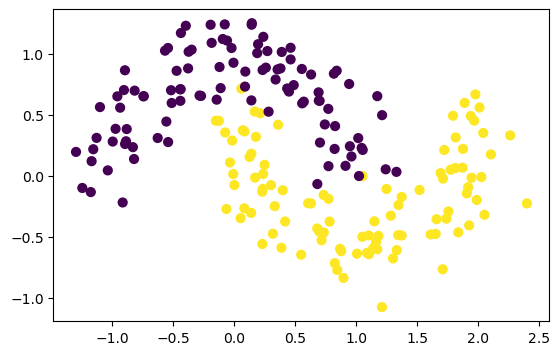

In [6]:
fig = plot_data(x, v)

We want to partition this domain into 2 regions, such that when we come in with a new point, we know which group it belongs to.

First we setup and train our network

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop

2024-04-07 17:50:46.064314: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 17:50:46.067558: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 17:50:46.124319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 17:50:47.260367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
model = Sequential()
model.add(Dense(50, input_dim=2, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

/home/zingale/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
rms = RMSprop()
model.compile(loss='binary_crossentropy',
              optimizer=rms, metrics=['accuracy'])

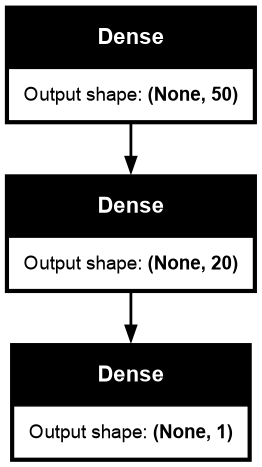

In [10]:
from IPython.display import SVG
from keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=100)

We seem to need a lot of epochs here to get a good result

In [11]:
epochs = 100
results = model.fit(x, v, batch_size=50, epochs=epochs)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1647 - loss: 0.7254  
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5433 - loss: 0.6917 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.6705 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8420 - loss: 0.6502 
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8593 - loss: 0.6293 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8567 - loss: 0.6112 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8593 - loss: 0.5908 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8787 - loss: 0.5688 
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8813 - loss: 0.5580 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8673 - loss: 0.5425 
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8593 - loss: 0.5297 
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8773 - lo

In [12]:
score = model.evaluate(x, v, verbose=0)
print(f"score = {score[0]}")
print(f"accuracy = {score[1]}")

score = 0.24797368049621582
accuracy = 0.8999999761581421


Let's look at a prediction.  We need to feed in a single point as an array of shape `(N, 2)`, where `N` is the number of points

In [13]:
res = model.predict(np.array([[-2, 2]]))
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[4.0399346e-08]], dtype=float32)

We see that we get a floating point number.  We will need to convert this to 0 or 1 by rounding.

Let's plot the partitioning

In [14]:
M = 128
N = 128

xmin = -1.75
xmax = 2.5
ymin = -1.25
ymax = 1.75

xpt = np.linspace(xmin, xmax, M)
ypt = np.linspace(ymin, ymax, N)

To make the prediction go faster, we want to feed in a vector of these points, of the form:
```
[[xpt[0], ypt[0]],
 [xpt[1], ypt[1]],
 ...
]
```

We can see that this packs them into the vector

In [15]:
pairs = np.array(np.meshgrid(xpt, ypt)).T.reshape(-1, 2)
pairs[0]

array([-1.75, -1.25])

Now we do the prediction.  We will get a vector out, which we reshape to match the original domain.

In [16]:
res = model.predict(pairs, verbose=0)
res.shape = (M, N)

Finally, round to 0 or 1

In [17]:
domain = np.where(res > 0.5, 1, 0)

and we can plot the data

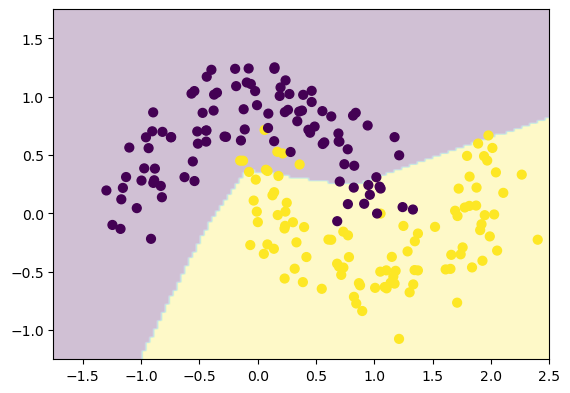

In [18]:
fig, ax = plt.subplots()
ax.imshow(domain.T, origin="lower",
          extent=[xmin, xmax, ymin, ymax], alpha=0.25)
xpt = [q[0] for q in x]
ypt = [q[1] for q in x]

ax.scatter(xpt, ypt, s=40, c=v, cmap="viridis")